In [ ]:
import os
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob

# قسمت ب

## pretrained alexnet

In [ ]:
net = torchvision.models.alexnet(pretrained=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

cuda


## preprocessing

In [ ]:
# ! mkdir test_images
! wget https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02090721_Irish_wolfhound.JPEG -P test_images
! wget https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01537544_indigo_bunting.JPEG -P test_images
! wget https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01440764_tench.JPEG -P test_images
! wget https://gitlab.com/ronctli1012/blog1-pretrained-alexnet-and-visualization/-/raw/master/class_names_ImageNet.txt


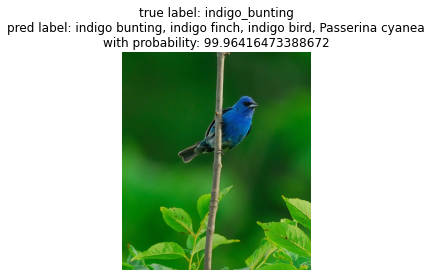

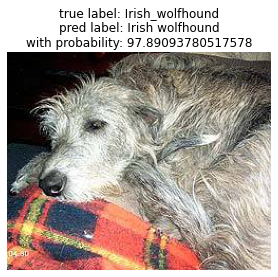

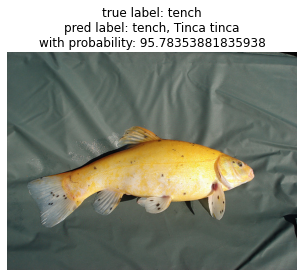

<Figure size 432x288 with 0 Axes>

In [ ]:
img_transforms = transforms.Compose([
        transforms.Resize((224,224)),            
        transforms.ToTensor(),              
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # the normalization is based on images from ImageNet
    ])

with open('class_names_ImageNet.txt') as labels:
  classes = [i.strip() for i in labels.readlines()]

test_images_dir = 'test_images'
test_images_filepath = glob.glob(f'{test_images_dir}/*')
for images_path in test_images_filepath:
  img = Image.open(images_path)
  transformed_img = img_transforms(img)
  batch_img = torch.unsqueeze(transformed_img, 0)
  batch_img = batch_img.to(device)
  net.eval()
  output = net(batch_img)

  best = torch.argmax(output)
  percentage = nn.Softmax(dim=1)(output)[0] * 100.0
  prob = percentage[best].item()
  pred_label = classes[best] 

  true_label = '_'.join(images_path.split('_')[2:]).split('.')[0]

  plt.imshow(img)
  plt.title(f'true label: {true_label}\npred label: {pred_label}\nwith probability: {prob}')
  plt.axis('off')
  plt.figure()

# قسمت د

## CIFAR10 dataset
with 10 classes


In [ ]:
  os.path.join("/tmp/cifar10"),
  train=True,
  download=True,
  transform=img_transforms)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset)*0.8), int(len(train_dataset)*0.2)])

test_dataset = datasets.CIFAR10(
  os.path.join("/tmp/cifar10"),
  train=False,
  download=True,
  transform=img_transforms)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f'train length:', len(train_dataset))
print(f'validation length:', len(val_dataset))
print(f'test length:', len(test_dataset))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /tmp/cifar10/cifar-10-python.tar.gz to /tmp/cifar10
Files already downloaded and verified
train length: 40000
validation length: 10000
test length: 10000


In [ ]:
train_sampler = torch.utils.data.RandomSampler(train_dataset)
val_sampler = torch.utils.data.RandomSampler(val_dataset)
test_sampler = torch.utils.data.RandomSampler(test_dataset)

batch_size = 30

train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size,
  sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(
  val_dataset,
  batch_size=batch_size,
  sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=batch_size,
  sampler=test_sampler)

### alexnet

In [ ]:
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### freeze pretrained alexnet params

In [ ]:
for param in net.parameters():
    param.requires_grad = False

### change the alexnet classifier part

In [ ]:
num_labels = len(classes)
classifier = nn.Sequential(nn.Dropout(p=0.5, inplace=False),
                           nn.Linear(net.classifier[1].in_features, net.classifier[1].out_features, bias=True),
                           nn.ReLU(inplace=True),
                           nn.Dropout(p=0.5, inplace=False),
                           nn.Linear(net.classifier[4].in_features, net.classifier[4].out_features, bias=True),
                           nn.ReLU(inplace=True),
                           nn.Linear(net.classifier[6].in_features, num_labels, bias=True))

net.classifier = classifier
net = net.to(device)

In [ ]:
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

epoch: 0 finished
epoch: 1 finished
epoch: 2 finished
epoch: 3 finished
epoch: 4 finished


<Figure size 432x288 with 0 Axes>

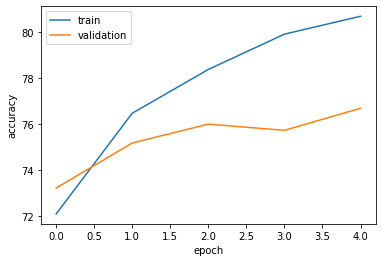

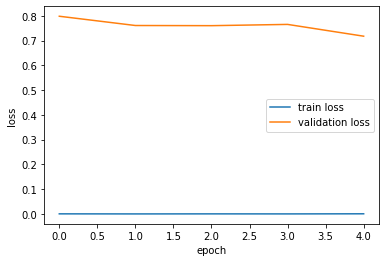

<Figure size 432x288 with 0 Axes>

In [ ]:
num_epochs = 5
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

net.train()

loss_train = []
loss_val = []

acc_train = []
acc_val = []

for epoch in range(num_epochs):
  num_correct = 0
  total_guesses = 0
  losses = 0
  for data, targets in iter(train_loader):
    data = data.to(device)
    targets = targets.to(device)

    results = net(data)
    preds = torch.argmax(results, 1)

    num_correct += torch.eq(targets, preds).sum().item()
    total_guesses += batch_size

    loss = loss_fn(results, targets)
    losses += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  acc_train.append(num_correct/total_guesses*100)
  loss_train.append(loss/len(train_loader))

  with torch.no_grad():
    num_correct = 0
    total_guesses = 0
    loss = 0
    for data, targets in iter(val_loader):
      data = data.to(device)
      targets = targets.to(device)

      results = net(data)
      preds = torch.argmax(results, 1)


      num_correct += torch.eq(targets, preds).sum().item()
      total_guesses += batch_size

      loss += loss_fn(results, targets).item()

    acc_val.append(num_correct/total_guesses*100)
    loss_val.append(loss/len(val_loader))

  print(f'epoch: {epoch} finished')

plt.plot(acc_train, label='train')
plt.plot(acc_val, label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.figure()
plt.plot(loss_train, label='train loss')
plt.plot(loss_val, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

In [ ]:

def test_network(net, test_loader):
  num_correct = 0
  total_guesses = 0

  net.eval()

  cm = np.zeros((num_labels, num_labels))
  y_true = []
  y_pred = []

  with torch.no_grad():
    for data, targets in iter(test_loader):
      data = data.to(device)
      targets = targets.to(device)

      results = net(data)
      preds = torch.argmax(results, 1)

      num_correct += torch.eq(targets, preds).sum().item()
      total_guesses += batch_size

      y_true.extend(targets.cpu().squeeze().detach().numpy().tolist())
      y_pred.extend(preds.cpu().squeeze().detach().numpy().tolist())
      for i in range(len(preds)):
        cm[int(targets[i].item()), int(preds[i].item())] += 1
    
    print("Correctly guessed ", num_correct/total_guesses*100, "% of the dataset")
    print(cm)

test_network(net, test_loader)


Correctly guessed  83.40319361277444 % of the dataset
[[855.  15.  12.  23.   7.   1.   0.  14.  58.  15.]
 [ 16. 941.   0.   7.   1.   0.   1.   1.   8.  25.]
 [ 56.   1. 678.  71.  82.  32.  42.  28.   8.   2.]
 [  8.   1.  21. 770.  32. 105.  24.  26.   7.   6.]
 [ 17.   1.  10.  39. 837.  13.  21.  59.   3.   0.]
 [  2.   3.   8. 142.  36. 763.  10.  35.   1.   0.]
 [  3.   3.  16.  56.  42.   7. 861.   9.   3.   0.]
 [ 14.   1.   3.  26.  44.  12.   0. 898.   1.   1.]
 [ 40.  30.   2.   7.   0.   0.   2.   2. 909.   8.]
 [ 31.  83.   0.  11.   2.   1.   0.   8.  19. 845.]]
